# Machine Learning Library Strategy

In [172]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

from dask import dataframe as dd
from dask import delayed
from dask.distributed import Client

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from ncbi_remap.plotting import make_figs
from ncbi_remap.normalization import cpm

# Connect to data store
store = pd.HDFStore('../sra.h5', mode='r')
samples = store['aln/complete'].srx.unique().tolist()

In [97]:
from pymongo import MongoClient
try:
    with open('../output/.mongodb_host', 'r') as fh:
        host = fh.read().strip()
except FileNotFoundError:
    host = 'localhost'

mongoClient = MongoClient(host=host, port=27017)
db = mongoClient['sra']
ncbi = db['ncbi']

In [99]:
labels = pd.DataFrame(list(ncbi.aggregate([
    {
        '$match': {
            '_id': {'$in': samples}
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$_id',
            'library_strategy': '$sra.experiment.library_strategy'
        }
    }
    
])))
labels.set_index('srx', inplace=True)
labels.head()

,library_strategy
srx,
DRX000774,OTHER
DRX000775,OTHER
DRX000998,WGS
DRX000999,WGS
DRX001000,WGS


## Normalized read counts

In [84]:
df = pd.read_parquet('../downstream-analysis/output/counts_norm_median.parquet')
data = df.join(labels)

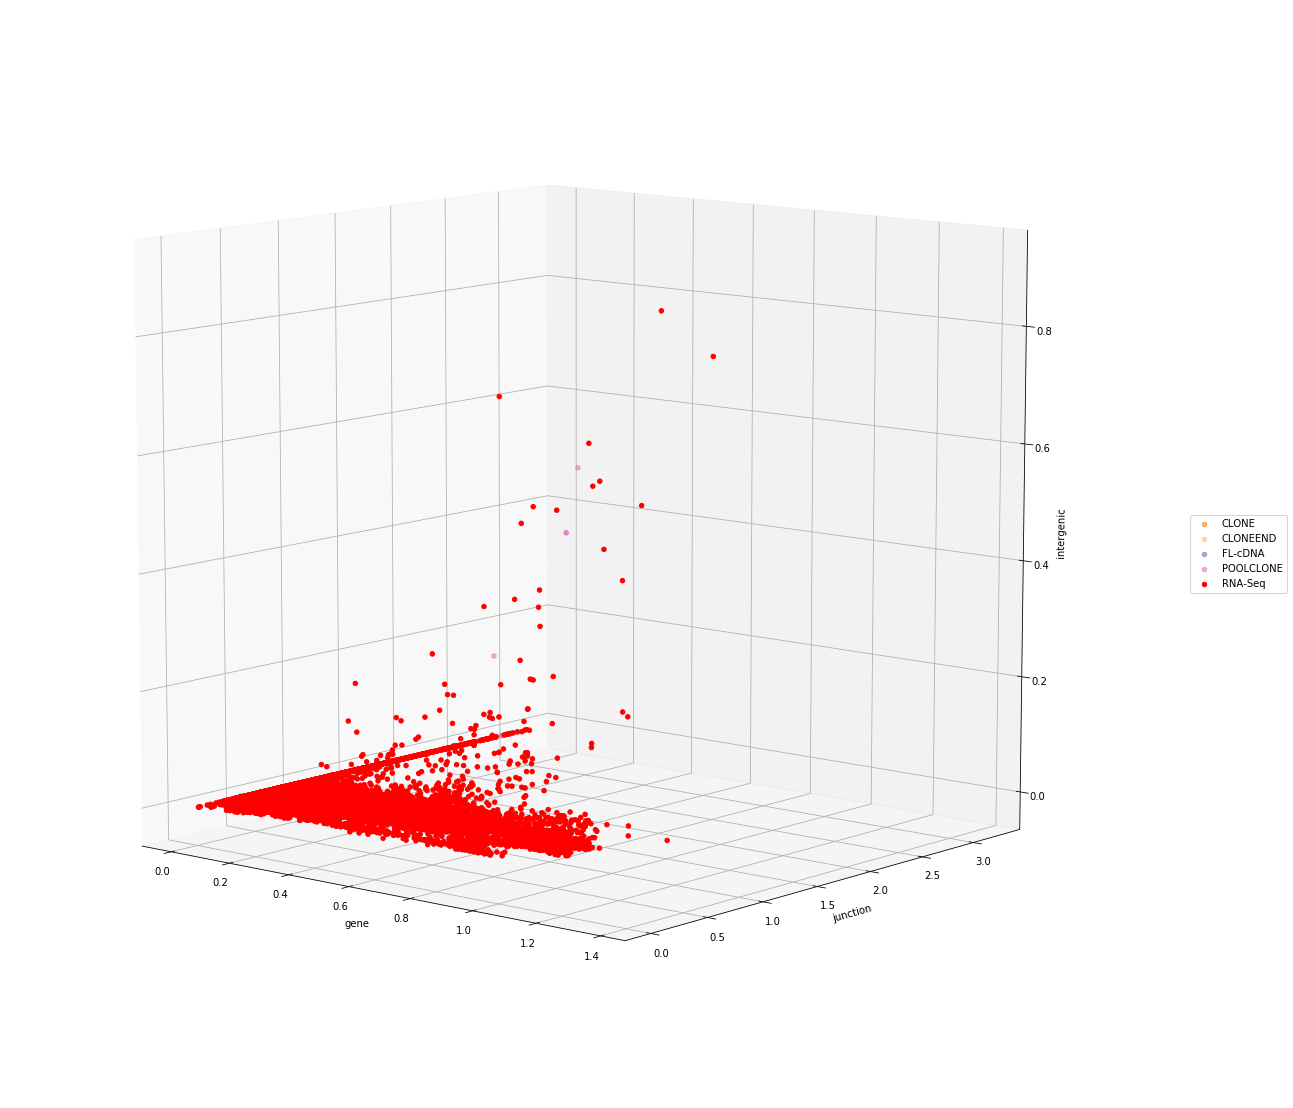

In [171]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

for (g, _dd), color in zip(data.groupby('library_strategy'), sns.color_palette('tab20', n_colors=20)):
    if g in ['WGS', 'ChIP-Seq', 'MNase-Seq', 'OTHER', 'EST', 'miRNA-Seq', 
             'ncRNA-Seq', 'FAIRE-seq', 'Targeted-Capture', 'RIP-Seq', 'MeDIP-Seq',
             'AMPLICON', 'Bisulfite-Seq', 'DNase-Hypersensitivity', 'WGA',
            ]:
        continue
    if g == 'RNA-Seq':
        alpha=1
        color='r'
    else:
        alpha=.6
        
    ax.scatter(_dd.gene, _dd.junction, _dd.intergenic, label=g, alpha=alpha, c=color)
    
ax.set_xlabel('gene')
ax.set_ylabel('junction')
ax.set_zlabel('intergenic')
plt.legend(loc='center', bbox_to_anchor=(1.1, 0.5))
ax.elev = ax.elev - 20
ax.azim = ax.azim + 10

## Focus on RNA-Seq

In [175]:
rnaseq = labels.query('library_strategy == "RNA-Seq"').index.tolist()

In [176]:
rnaseq

['DRX013093',
 'DRX013094',
 'DRX014765',
 'DRX014766',
 'DRX014767',
 'DRX014768',
 'DRX014769',
 'DRX014770',
 'DRX014771',
 'DRX014772',
 'DRX014773',
 'DRX014774',
 'DRX014775',
 'DRX014776',
 'DRX014777',
 'DRX014778',
 'DRX014779',
 'DRX014780',
 'DRX014781',
 'DRX014782',
 'DRX014783',
 'DRX014784',
 'DRX014785',
 'DRX014786',
 'DRX014787',
 'DRX014788',
 'DRX014789',
 'DRX014790',
 'DRX014791',
 'DRX014792',
 'DRX014793',
 'DRX014794',
 'DRX014795',
 'DRX014796',
 'DRX014797',
 'DRX014798',
 'DRX014799',
 'DRX014800',
 'DRX014801',
 'DRX014802',
 'DRX014803',
 'DRX014804',
 'DRX014805',
 'DRX014806',
 'DRX014807',
 'DRX014808',
 'DRX014809',
 'DRX014810',
 'DRX014811',
 'DRX014812',
 'DRX017244',
 'DRX017245',
 'DRX017246',
 'DRX017247',
 'DRX017248',
 'DRX017249',
 'DRX017250',
 'DRX017251',
 'DRX017252',
 'DRX017253',
 'DRX017254',
 'DRX017255',
 'DRX017256',
 'DRX017257',
 'DRX017258',
 'DRX017259',
 'DRX017260',
 'DRX017262',
 'DRX017263',
 'DRX017264',
 'DRX017265',
 'DRX0

In [187]:
all_rnaseq = [x['_id'] for x in ncbi.aggregate([
    {
        '$match': {
            'sra.experiment.library_strategy': 'RNA-Seq'
        }
    },
    {
        '$project': {
            '_id': 1,
        }
    }
    
])]

In [188]:
len(all_rnaseq)

15558

In [189]:
missing = [x for x in all_rnaseq if x not in samples]

In [190]:
len(missing)

1729

In [192]:
with open('../aln-wf/output/priority.txt', 'w') as fo:
    fo.write('\n'.join(missing))